In [147]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [148]:
df = pd.read_csv("FINAL-BDA-dataset(original_dataset).csv")
df_translated = pd.read_csv("FINAL-BDA-dataset(translated_dataset).csv")

In [149]:
df.duplicated().sum()

0

In [150]:
quantiles = df.quantile([0.25, 0.75], numeric_only=True)

In [151]:
IQR = quantiles.loc[0.75] - quantiles.loc[0.25]

In [152]:
top_limit = quantiles.loc[0.75] + 1.5 * IQR
bottom_limit = quantiles.loc[0.25] - 1.5 * IQR
df_numeric = df.select_dtypes(include=["number"])
outlier_mask = (df_numeric > top_limit) | (df_numeric < bottom_limit)

In [153]:
outlier_mask.sum()

Marital status                                     505
Application mode                                     0
Application order                                  541
Course                                               0
Daytime/evening attendance                         483
Previous qualification                             707
Nacionality                                        110
Mother's qualification                               0
Father's qualification                               0
Mother's occupation                                 84
Father's occupation                                 84
Displaced                                            0
Educational special needs                           51
Debtor                                             503
Tuition fees up to date                            528
Gender                                               0
Scholarship holder                                1099
Age at enrollment                                  441
Internatio

In [154]:
df["total_enrolled"] = (
    df["Curricular units 1st sem (enrolled)"]
    + df["Curricular units 2nd sem (enrolled)"]
)

In [155]:
df["total_approved"] = (
    df["Curricular units 1st sem (approved)"]
    + df["Curricular units 2nd sem (approved)"]
)

In [156]:
df["approval_rate"] = df["total_approved"] / df["total_enrolled"]

In [157]:
df["overall_grade"] = df[
    ["Curricular units 1st sem (grade)", "Curricular units 2nd sem (grade)"]
].mean(axis="columns")

In [158]:
out_share = (
    (df["Target"].value_counts(normalize=True) * 100)
    .round(1)
    .sort_values(ascending=False)
)
out_share

Target
Graduate    49.9
Dropout     32.1
Enrolled    17.9
Name: proportion, dtype: float64

In [ ]:
medians = (
    df.groupby("Target")[["approval_rate", "overall_grade", "total_enrolled"]]
    .median()
    .round(2)
)
medians

,approval_rate,overall_grade,total_enrolled
Target,,,
Dropout,0.30,6.50,12.0
Enrolled,0.75,11.92,12.0
Graduate,1.00,13.00,12.0


In [160]:
sns.set(style="whitegrid")

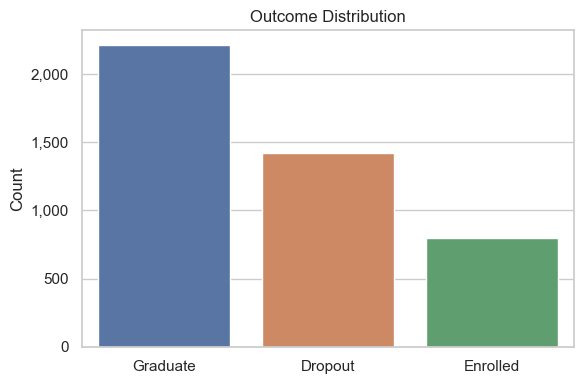

In [ ]:
# # 1) Outcome distribution
fig, ax = plt.subplots(figsize=(6, 4))
labels = out_share.index
sns.countplot(x="Target", data=df, order=labels, ax=ax)
ax.set_title("Outcome Distribution")
ax.set_ylabel("Count")
ax.set_xlabel("")
ax.yaxis.set_major_formatter("{:,.0f}".format)
fig.tight_layout()
plt.show()

In [ ]:
# Get whatever color palette the first plot used.
colors = [p.get_facecolor() for p in ax.patches]
palette = dict(zip(labels, colors, strict=False))

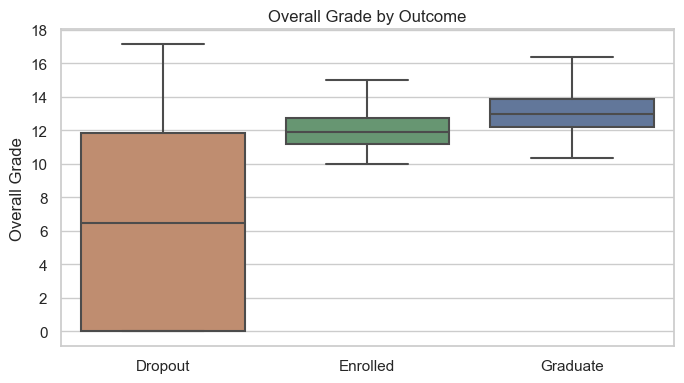

In [ ]:
# 3) Overall grade by outcome (boxplot)
fig, ax = plt.subplots(figsize=(7, 4))
order = df.groupby("Target")["overall_grade"].median().sort_values().index
sns.boxplot(x="Target", y="overall_grade", data=df, order=order, palette=palette, ax=ax)
ax.set_title("Overall Grade by Outcome")
ax.set_xlabel("")
ax.set_ylabel("Overall Grade")
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
fig.tight_layout()
plt.show()

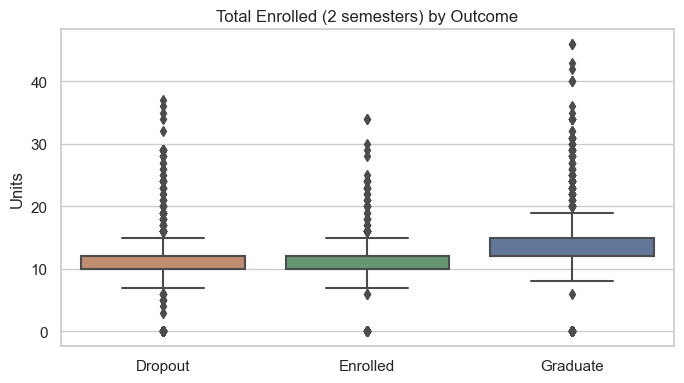

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
order = df.groupby("Target")["total_enrolled"].median().sort_values().index
sns.boxplot(
    x="Target", y="total_enrolled", data=df, order=order, palette=palette, ax=ax
)
ax.set_title("Total Enrolled (2 semesters) by Outcome")
ax.set_xlabel("")
ax.set_ylabel("Units")
fig.tight_layout()
plt.show()

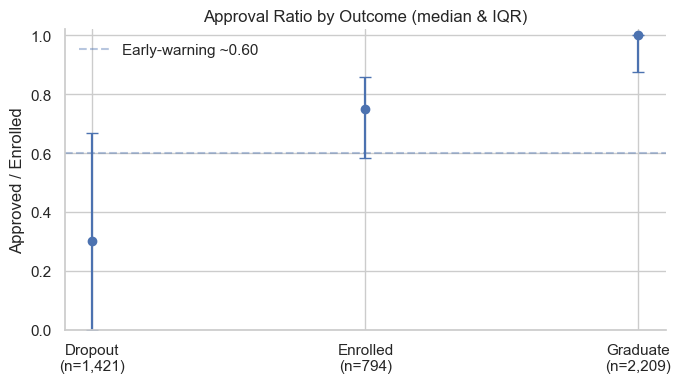

In [165]:
g = (
    df.groupby("Target")["approval_rate"]
    .agg(
        median="median",
        q1=lambda s: s.quantile(0.25),
        q3=lambda s: s.quantile(0.75),
        n="size",
    )
    .sort_values("median")
)

x = np.arange(len(g))
fig, ax = plt.subplots(figsize=(7, 4))
ax.errorbar(
    x,
    g["median"],
    yerr=[g["median"] - g["q1"], g["q3"] - g["median"]],
    fmt="o",
    capsize=4,
    linewidth=1.6,
)
ax.axhline(0.60, ls="--", alpha=0.4, label="Early-warning ~0.60")
ax.set_xticks(x)
ax.set_xticklabels(
    [f"{k}\n(n={int(n):,})" for k, n in zip(g.index, g["n"], strict=False)]
)
ax.set_ylim(0, 1.02)
ax.set_ylabel("Approved / Enrolled")
ax.set_title("Approval Ratio by Outcome (median & IQR)")
ax.legend(frameon=False)
sns.despine()
plt.tight_layout()
plt.show()